<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_Deep_Learning_Con_TernsorFlow_Machine-Learning_e_IA-/blob/master/scripts/tema09/05-deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow==1.15

# Deep Dream

In [0]:
!mkdir models
!mkdir models/inception5h

In [11]:
!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip 

--2020-06-13 21:41:11--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  75.0MB/s    in 0.6s    

2020-06-13 21:41:11 (75.0 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]



In [15]:
!unzip models/inception/inception5h.zip models/inception

Archive:  models/inception/inception5h.zip
caution: filename not matched:  models/inception


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from io import BytesIO

In [28]:
graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
model_nn = "models/inception5h/tensorflow_inception_graph.pb"
with tf.gfile.FastGFile(model_nn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    # vamos a leer de ese fichero .pb toda la info relativa de los nodos

In [0]:
t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean,0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [0]:
layers = [op.name for op in graph.get_operations() if op.type=="Conv2D" and "import/" in op.name]

In [34]:
# NUMERO DE CAPAS DE LA NEURONA
layers

['import/conv2d0_pre_relu/conv',
 'import/conv2d1_pre_relu/conv',
 'import/conv2d2_pre_relu/conv',
 'import/mixed3a_1x1_pre_relu/conv',
 'import/mixed3a_3x3_bottleneck_pre_relu/conv',
 'import/mixed3a_3x3_pre_relu/conv',
 'import/mixed3a_5x5_bottleneck_pre_relu/conv',
 'import/mixed3a_5x5_pre_relu/conv',
 'import/mixed3a_pool_reduce_pre_relu/conv',
 'import/mixed3b_1x1_pre_relu/conv',
 'import/mixed3b_3x3_bottleneck_pre_relu/conv',
 'import/mixed3b_3x3_pre_relu/conv',
 'import/mixed3b_5x5_bottleneck_pre_relu/conv',
 'import/mixed3b_5x5_pre_relu/conv',
 'import/mixed3b_pool_reduce_pre_relu/conv',
 'import/mixed4a_1x1_pre_relu/conv',
 'import/mixed4a_3x3_bottleneck_pre_relu/conv',
 'import/mixed4a_3x3_pre_relu/conv',
 'import/mixed4a_5x5_bottleneck_pre_relu/conv',
 'import/mixed4a_5x5_pre_relu/conv',
 'import/mixed4a_pool_reduce_pre_relu/conv',
 'import/mixed4b_1x1_pre_relu/conv',
 'import/mixed4b_3x3_bottleneck_pre_relu/conv',
 'import/mixed4b_3x3_pre_relu/conv',
 'import/mixed4b_5x5_bo

## ACTIVAR GPU DE COLAB

In [36]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
feature_num = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

In [41]:
feature_num

[64,
 64,
 192,
 64,
 96,
 128,
 16,
 32,
 32,
 128,
 128,
 192,
 32,
 96,
 64,
 192,
 96,
 204,
 16,
 48,
 64,
 160,
 112,
 224,
 24,
 64,
 64,
 128,
 128,
 256,
 24,
 64,
 64,
 112,
 144,
 288,
 32,
 64,
 64,
 256,
 160,
 320,
 32,
 128,
 128,
 256,
 160,
 320,
 48,
 128,
 128,
 384,
 192,
 384,
 48,
 128,
 128,
 128,
 128]

In [0]:

im_noise = np.random.uniform(size = (224,224,3))+100.0

In [0]:
def show_array(a, fmt = "jpeg"):
    a = np.uint8(np.clip(a,0,1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    plt.imshow(a)

In [0]:
def T(layer):
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [0]:
def tf_func(*argtypes):
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

In [0]:
def resize(img, size):
    img = tf.expand_dims(img,0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

In [0]:
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h,w = img.shape[:2]
    sx, sy = np.random.randint(sz,size = 2)
    img_shift = np.roll(np.roll(img,sx,1),sy,0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz), sz):
        for x in range(0, max(w-sz//2, sz), sz):
            sub = img_shift[y:y+sz, x:x+sz]
            g = session.run(t_grad, {t_input:sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy,0)

In [0]:
def render_deepdream(t_obj, img0=im_noise, iter_n = 10, step = 1.5, octave_n = 4, octave_scale = 1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]#empezamos desde el último octave la reconstrucción
            img = resize(img, hi.shape[:2]) + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print(".", end=" ")
        show_array(img/255.0)

In [0]:
resize = tf_func(np.float32, np.int32)(resize)

In [63]:
resize

<function __main__.tf_func.<locals>.wrap.<locals>.wrapper>

In [0]:
img0 = PIL.Image.open('original_image.jpg')
img0 = np.float32(img0)

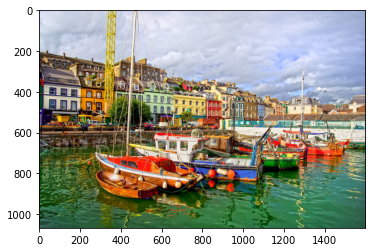

In [69]:
show_array(img0/255.0)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

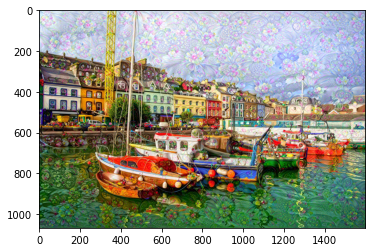

In [70]:
render_deepdream(T(layer)[:,:,:,139], img0=img0, iter_n=15)

## Creamos la imagen con GPU

In [72]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def GPU_PROCESO(Funcion_proceso):
    
  import timeit

  def entrenamiento_gpu():
    with tf.device('/device:GPU:0'):
      Funcion_proceso
      print('ejecutado')
    return None
  gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')
  print('tiempo de entrenamiento '+ str(gpu_time)+ ' segundos')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ejecutado
tiempo de entrenamiento 40.90516029000037 segundos


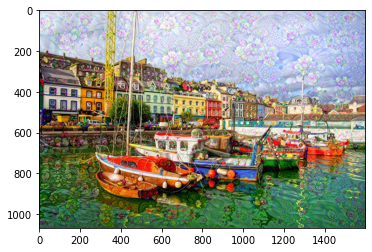

In [79]:
layer = "mixed4d_3x3_bottleneck_pre_relu"
channel = 139
Funcion_proceso = render_deepdream(T(layer)[:,:,:,channel], img0=img0, iter_n=15)
GPU_PROCESO(Funcion_proceso)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ejecutado
tiempo de entrenamiento 41.735594791999574 segundos


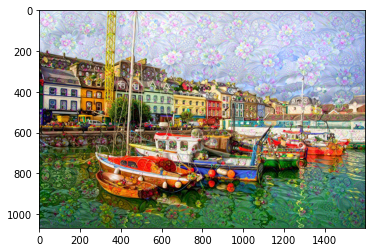

In [80]:
layer = "mixed4d_3x3_bottleneck_pre_relu"
channel = 50
Funcion_proceso = render_deepdream(T(layer)[:,:,:,channel], img0=img0, iter_n=15)
GPU_PROCESO(Funcion_proceso)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ejecutado
tiempo de entrenamiento 49.878629015000115 segundos


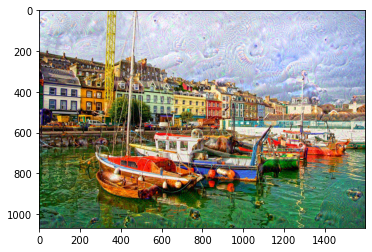

In [84]:
layer = "mixed5b_3x3_bottleneck_pre_relu"
channel = 27 # neurona
Funcion_proceso = render_deepdream(T(layer)[:,:,:,channel], img0=img0, iter_n=15)
GPU_PROCESO(Funcion_proceso)


Inception in TensorFlow
https://github.com/tensorflow/models/tree/master/research/inception

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

ValueError: ignored

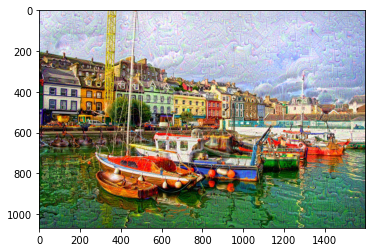

In [85]:
layer = "head1_bottleneck_pre_relu"
channel = 30 # neurona
Funcion_proceso = render_deepdream(T(layer)[:,:,:,channel], img0=img0, iter_n=15)
GPU_PROCESO(Funcion_proceso)